In [7]:
rm-rf sample_data/

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.layers import Input, ReLU
from keras.models import Sequential, load_model
from keras.optimizers import Adam
import math
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import pickle
#training set: 80%    :162079
#testing set: 20%     :40520

In [13]:
!pip install kaggle
!mkdir /root/.kaggle
!mv  kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d ahmedshawaf/celeba
!unzip 'celeba.zip'


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: img_align_celeba/197601.jpg  
  inflating: img_align_celeba/197602.jpg  
  inflating: img_align_celeba/197603.jpg  
  inflating: img_align_celeba/197604.jpg  
  inflating: img_align_celeba/197605.jpg  
  inflating: img_align_celeba/197606.jpg  
  inflating: img_align_celeba/197607.jpg  
  inflating: img_align_celeba/197608.jpg  
  inflating: img_align_celeba/197609.jpg  
  inflating: img_align_celeba/197610.jpg  
  inflating: img_align_celeba/197611.jpg  
  inflating: img_align_celeba/197612.jpg  
  inflating: img_align_celeba/197613.jpg  
  inflating: img_align_celeba/197614.jpg  
  inflating: img_align_celeba/197615.jpg  
  inflating: img_align_celeba/197616.jpg  
  inflating: img_align_celeba/197617.jpg  
  inflating: img_align_celeba/197618.jpg  
  inflating: img_align_celeba/197619.jpg  
  inflating: img_align_celeba/197620.jpg  
  inflating: img_align_celeba/197621.jpg  
  inflating: img_al

In [14]:
%cd /content/
!mkdir test
!mkdir train

/content
mkdir: cannot create directory ‘test’: File exists
mkdir: cannot create directory ‘train’: File exists


In [15]:
cd /content/img_align_celeba

/content/img_align_celeba


In [16]:
!mv 0{00001..40520}.jpg /content/test/
print("test done")
!mv {040521..100000}.jpg /content/train/
!mv {100001..200000}.jpg /content/train/
!mv {200001..202599}.jpg /content/train/
print("train done")

test done
train done


In [17]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at:{}'.format(device_name))

Found GPU at:/device:GPU:0


In [18]:
def load(DATADIR, offset=0, size=0, normalization=True):
    data = []
    path = os.path.join(DATADIR,'')
    if size == 0:
      imgs = os.listdir(path)[offset:]
    else:
      imgs = os.listdir(path)[offset:offset+size]
    #print(np.array(imgs).shape)
    for img in imgs:
        img = Image.open(os.path.join(path,img))
        if normalization:
          img_array = np.array(img).astype(np.float32)/ 255
        else:
          img_array = np.array(img)
        data.append(img_array)
        
    return np.array(data)

In [19]:
def count_data(DATADIR):
    path = os.path.join(DATADIR, '')
    data = os.listdir(path)[:]
    return np.array(data).shape[0]

In [20]:
image_shape = load('/content/train/', size=1)[0].shape

In [21]:
image_shape

(218, 178, 3)

In [22]:
class GAN:
    def __init__(self, image_shape):
        self.input_shape = image_shape
        self.learning_rate = 1e-4
        self.beta_1 = 0.9
        self.beta_2 = 0.999
        self.D = None   # discriminator
        self.G = None   # generator
        self.DM = None  # discriminator model
        self.GM = None  # generator model
        self.AM = None  # adversarial model
        
    def discriminator(self):
        if self.D:
            return self.D
        self.D = Sequential()
        dropout = 0.2
        leakyReluAlpha = 0.2
        
        #Start the model
        #Layer1
        self.D.add(Conv2D(32, kernel_size=(3, 3), strides=(2, 2), input_shape=self.input_shape, padding='same'))
        self.D.add(BatchNormalization())
        self.D.add(LeakyReLU(alpha=leakyReluAlpha))
        self.D.add(Dropout(dropout))
        #Layer2
        self.D.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
        self.D.add(BatchNormalization())
        self.D.add(LeakyReLU(alpha=leakyReluAlpha))
        self.D.add(Dropout(dropout))
        #Layer3
        self.D.add(Conv2D(128, (3,3), strides=(2, 2), padding='same'))
        self.D.add(BatchNormalization())
        self.D.add(LeakyReLU(alpha=leakyReluAlpha))
        self.D.add(Dropout(dropout))
        #Layer4 - OutputLayer
        self.D.add(Flatten())
        self.D.add(Dense(1, activation='sigmoid'))
        
        #self.D.summary()
        return self.D
    
    def generator(self):
        if self.G:
            return self.G
        self.G = Sequential()
        
        #Start the model
        #encoding
        #Layer1 change the line 62, omit the None in the shape
        self.G.add(Conv2D(32, (3, 3), strides=(2, 2), input_shape=(self.input_shape[0], self.input_shape[1], self.input_shape[2]+1), padding='same'))
        self.G.add(BatchNormalization())
        self.G.add(Activation('relu'))
        #Layer2
        self.G.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
        self.G.add(BatchNormalization())
        self.G.add(Activation('relu'))
        #Layer3
        self.G.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
        self.G.add(BatchNormalization())
        self.G.add(Activation('relu'))
        #Layer4
        self.G.add(Conv2D(128, (3, 3), strides=(2, 2)))
        self.G.add(BatchNormalization())
        self.G.add(Activation('relu'))
        
        #decoding
        #Layer5
        self.G.add(Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same'))
        self.G.add(BatchNormalization())
        self.G.add(Activation('relu'))
        #Layer6
        self.G.add(Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same'))
        self.G.add(BatchNormalization())
        self.G.add(Activation('relu'))
        #Layer7
        self.G.add(Conv2DTranspose(32, (3, 3), strides=(1, 1), padding='same'))
        self.G.add(BatchNormalization())
        self.G.add(Activation('relu'))
        #Layer8
        self.G.add(Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same'))
        self.G.add(BatchNormalization())
        self.G.add(Activation('relu'))
        #Layer9
        self.G.add(Conv2DTranspose(3, (3, 3), strides=(1, 1)))
        self.G.add(Activation('sigmoid'))

        #self.G.summary()
        return self.G

    def discriminator_model(self):
        if self.DM:
            return self.DM
        optimizer = Adam(learning_rate=self.learning_rate, beta_1=self.beta_1, beta_2=self.beta_2)
        self.DM = Sequential()
        self.DM.add(self.discriminator())
        self.DM.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return self.DM

    def generator_model(self):
        if self.GM:
            return self.GM
        optimizer = Adam(learning_rate=self.learning_rate, beta_1=self.beta_1, beta_2=self.beta_2)
        self.GM = Sequential()
        self.GM.add(self.generator())
        self.GM.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
        return self.GM

    def adversarial_model(self):
        if self.AM:
            return self.AM
        optimizer = Adam(learning_rate=self.learning_rate, beta_1=self.beta_1, beta_2=self.beta_2)
        self.AM = Sequential()
        self.AM.add(self.generator())
        self.AM.add(self.discriminator())
        self.AM.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return self.AM

In [44]:
class GANInpaintingModel:
    def __init__(self, image_shape, learning_rate=1e-4, beta_1=0.9, beta_2=0.999):
    
        self.image_shape = image_shape

        self.save_path = '/content/GAN/'
                         
        self.GAN = GAN(image_shape=self.image_shape)
        self.discriminator = self.GAN.discriminator_model()
        self.generator = self.GAN.generator_model()
        self.adversarial = self.GAN.adversarial_model()
    
    def generate_masks_images(self, batch):
        
        def generate_mask_image(image):
            incomplete_image = np.copy(image)
          
            height = image.shape[0]
            width = image.shape[1]
            
            max_factor = 5
            min_factor = 6

            min_height_mask = int(height/min_factor)
            max_height_mask = int(height/max_factor)
            min_width_mask = int(width/min_factor)
            max_width_mask = int(width/max_factor)
            
            mask_height = np.random.randint(min_height_mask, max_height_mask)
            mask_width = np.random.randint(min_width_mask, max_width_mask)
            
            x = np.random.randint(0, height - mask_height)
            y = np.random.randint(0, width - mask_width)
            
           
            mask = np.zeros((height, width), dtype=float)
            mask[x:x+mask_height, y:y+mask_width] = 1.
            incomplete_image[x:x+mask_height, y:y+mask_width] = [1., 1., 1.]
            
            return (mask, incomplete_image)

        output_mask = []
        output_image = []
        for b in batch:
            m, i = generate_mask_image(b)
            output_mask.append(m)
            output_image.append(i)
        return np.array(output_mask), np.array(output_image)

    def images_plus_masks(self, masks, images):
        def image_plus_mask(mask, image):
            copy_image = np.copy(image)
            copy_mask = np.copy(mask)
            copy_mask = np.reshape(copy_mask, (copy_mask.shape[0], copy_mask.shape[1], 1))
            copy = np.concatenate((copy_image, copy_mask), axis=2)
            return copy
            
        output = []
        for i in range(len(masks)):
            output.append(image_plus_mask(masks[i], images[i]))
        return np.array(output)
    
    #save models
    def save_models(self):
        self.generator.save(
          self.save_path+'generator_model', 
          overwrite=True, 
          include_optimizer=True, 
          save_format='tf'
        )
        self.discriminator.save(
          self.save_path+'discriminator_model', 
          overwrite=True, 
          include_optimizer=True, 
          save_format='tf'
        )
        self.adversarial.save(
          self.save_path+'adversarial_model', 
          overwrite=True, 
          include_optimizer=True, 
          save_format='tf'
        )
      

    
    def evaluate(self,path_dataset_test,batch_size):
          #load validation data
          size_data_val = count_data(path_dataset_test)
          batch_count = int(float(size_data_val) / float(batch_size))
          pas_batch = 0
          metrics_val_disc, metrics_val_gen = np.array([0., 0.]), np.array([0., 0.])
          for i in tqdm(range(int(batch_count))):
              
              imgs_val = load(path_dataset_test, offset=pas_batch, size=batch_size, normalization=True)
              #generate incomplet images and masks
              masks, incomplete_images = gan.generate_masks_images(imgs_val)
              feed_prediction = gan.images_plus_masks(masks, incomplete_images)              
              masks = None
              incomplete_images = None

              #evaluate performance generator
              metrics_val_gen += self.generator.evaluate(feed_prediction,imgs_val, verbose=0)  
              
              #evaluate performance discriminator
              gen_imgs = self.generator.predict(feed_prediction)                  #generate images from generator model
              feed_prediction = None
              y = np.zeros(2*imgs_val.shape[0])                                   #constraint fake lable 
              y[:imgs_val.shape[0]] = 1                                           #constraint real lable
              x = np.concatenate((gen_imgs,imgs_val), axis=0)                     #concatenate real images and generated images              
              imgs_val = None
              gen_imgs = None
              metrics_val_disc += self.discriminator.evaluate(x,y, verbose=0)                                    #evaluate
              x = None
              y = None
              

              pas_batch += batch_size
              
          metrics_val_gen = metrics_val_gen / batch_count
          metrics_val_disc = metrics_val_disc / batch_count
          
          return (metrics_val_gen,metrics_val_disc)

    #load models
    def load_models(self):
      self.generator = load_model(self.save_path+'generator_model')
      self.discriminator = load_model(self.save_path+'discriminator_model')
      self.adversarial = load_model(self.save_path+'adversarial_model')


    def train(self, iterations=5, epochs=50, batch_size=256, save_interval=0, start_epoch=1, batch_offset=0):
        #uncomment to split
        #batch_count = math.ceil(count_data('/content/train') / batch_size) #there are 634 batches in total, for 10% use 64 batches
        batch_count = 64
        print('batch count:', batch_count, '.\n')
        initial_batch = batch_offset * batch_count

        #generate real and fake Y
        y_real = np.zeros((batch_size, 1))
        y_fake = np.ones((batch_size, 1))

        #loading the test_batch
        test_batch = load('/content/test/', size=1024)
        print('\nTest Data loaded..')
        for epoch in range(start_epoch, epochs+1):
            print('\nEpoch {}/{}\n'.format(epoch, epochs))

            print("Phase 1:\n")
            self.discriminator.trainable = True

            for n in range (1, iterations+1):
                current_batch_p1 = initial_batch #change to set the offset from the last training

                print('\nIteration-{}/{}\n'.format(n, iterations))
                for _ in tqdm(range(int(batch_count))):
                    
                    #load the current batch
                    real_batch = load('/content/train/', offset=current_batch_p1*batch_size, size=batch_size)
                    current_batch_p1 = current_batch_p1 + 1

                    #generate the data to feed to the generator
                    #so that the output of the generator is fed to the discriminator
                    masks, incomplete_images = self.generate_masks_images(real_batch)
                    feed_prediction = self.images_plus_masks(masks, incomplete_images)
                    del masks
                    del incomplete_images
                    fake_batch = self.generator.predict(feed_prediction)

                    #training the discriminator using the real data and the generated data
                    self.discriminator.train_on_batch(fake_batch, y_fake)
                    del fake_batch
                    self.discriminator.train_on_batch(real_batch, y_real)
                    
                    #train the generator using the real images
                    self.generator.train_on_batch(feed_prediction, real_batch)
                    del real_batch
                    del feed_prediction

            print("\nPhase 2:\n")
            current_batch_p2 = initial_batch #change to set the offset from the last training 
            
            #setting discriminator to not trainable, it's only used to train the generator
            self.discriminator.trainable = False
            for _ in tqdm(range(int(batch_count))):
                #load the current batch
                real_batch = load('/content/train/', offset=current_batch_p2*batch_size, size=batch_size)
                current_batch_p2 = current_batch_p2 + 1

                #generate the input for the adversarial model
                masks, incomplete_images = self.generate_masks_images(real_batch)
                del real_batch
                feed_prediction = self.images_plus_masks(masks, incomplete_images)
                del masks
                del incomplete_images

                #train the generator using the discriminator
                self.adversarial.train_on_batch(feed_prediction, y_real)
                del feed_prediction

            #save models (weights included)
            self.save_models()

            #testing the generator
            if epoch % 1 == 0:

                masks_test, incomplete_images_test = self.generate_masks_images(test_batch)
                test_feed_input = self.images_plus_masks(masks_test, incomplete_images_test)
                del masks_test
                del incomplete_images_test

                metrics_val = self.generator.evaluate(test_feed_input, test_batch, verbose=1)
                del test_feed_input
                print('\ngenerator:\nLoss :', metrics_val[0], '/Accuracy :', metrics_val[1])
                del metrics_val

In [45]:
#del gan
gan = GANInpaintingModel(image_shape)

In [46]:
gan.load_models()

In [47]:
#gan.generator.

In [48]:
'''gan.GAN.G.summary()
gan.GAN.D.summary()
gan.GAN.GM.summary()
gan.GAN.DM.summary()
gan.GAN.AM.summary()'''

'gan.GAN.G.summary()\ngan.GAN.D.summary()\ngan.GAN.GM.summary()\ngan.GAN.DM.summary()\ngan.GAN.AM.summary()'

In [ ]:
gan.train(iterations=3, epochs=50, batch_size=256, start_epoch=24, batch_offset=4)

batch count: 64 .



  0%|          | 0/64 [00:00<?, ?it/s]


Test Data loaded..

Epoch 24/50

Phase 1:


Iteration-1/3



  0%|          | 0/64 [00:00<?, ?it/s]


Iteration-2/3



  0%|          | 0/64 [00:00<?, ?it/s]


Iteration-3/3



  0%|          | 0/64 [00:00<?, ?it/s]


Phase 2:



100%|██████████| 64/64 [03:28<00:00,  3.26s/it]


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/GAN/generator_model/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/GAN/discriminator_model/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/GAN/adversarial_model/assets
32/32 [==============================] - 3s 99ms/step - loss: 5.7526e-04 - accuracy: 0.9321


  0%|          | 0/64 [00:00<?, ?it/s]


generator:
Loss : 0.0005752566503360868 /Accuracy : 0.9321134686470032

Epoch 25/50

Phase 1:


Iteration-1/3



  0%|          | 0/64 [00:00<?, ?it/s]


Iteration-2/3



  0%|          | 0/64 [00:00<?, ?it/s]


Iteration-3/3



  0%|          | 0/64 [00:00<?, ?it/s]


Phase 2:



100%|██████████| 64/64 [03:32<00:00,  3.32s/it]


INFO:tensorflow:Assets written to: /content/drive/My Drive/GAN/generator_model/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/GAN/discriminator_model/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/GAN/adversarial_model/assets
32/32 [==============================] - 3s 99ms/step - loss: 5.7775e-04 - accuracy: 0.9226


  0%|          | 0/64 [00:00<?, ?it/s]


generator:
Loss : 0.0005777503829449415 /Accuracy : 0.9226388335227966

Epoch 26/50

Phase 1:


Iteration-1/3



  0%|          | 0/64 [00:00<?, ?it/s]


Iteration-2/3



  0%|          | 0/64 [00:00<?, ?it/s]


Iteration-3/3



  0%|          | 0/64 [00:00<?, ?it/s]


Phase 2:



100%|██████████| 64/64 [03:31<00:00,  3.30s/it]


INFO:tensorflow:Assets written to: /content/drive/My Drive/GAN/generator_model/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/GAN/discriminator_model/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/GAN/adversarial_model/assets
32/32 [==============================] - 3s 100ms/step - loss: 5.9395e-04 - accuracy: 0.9206


  0%|          | 0/64 [00:00<?, ?it/s]


generator:
Loss : 0.0005939542897976935 /Accuracy : 0.9205753207206726

Epoch 27/50

Phase 1:


Iteration-1/3



  0%|          | 0/64 [00:00<?, ?it/s]


Iteration-2/3



  0%|          | 0/64 [00:00<?, ?it/s]


Iteration-3/3



  0%|          | 0/64 [00:00<?, ?it/s]


Phase 2:



100%|██████████| 64/64 [03:30<00:00,  3.29s/it]


INFO:tensorflow:Assets written to: /content/drive/My Drive/GAN/generator_model/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/GAN/discriminator_model/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/GAN/adversarial_model/assets
32/32 [==============================] - 3s 99ms/step - loss: 5.8587e-04 - accuracy: 0.9265


  0%|          | 0/64 [00:00<?, ?it/s]


generator:
Loss : 0.0005858739023096859 /Accuracy : 0.9264957904815674

Epoch 28/50

Phase 1:


Iteration-1/3



  0%|          | 0/64 [00:00<?, ?it/s]


Iteration-2/3



  0%|          | 0/64 [00:00<?, ?it/s]


Iteration-3/3



  0%|          | 0/64 [00:00<?, ?it/s]


Phase 2:



100%|██████████| 64/64 [03:29<00:00,  3.27s/it]


INFO:tensorflow:Assets written to: /content/drive/My Drive/GAN/generator_model/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/GAN/discriminator_model/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/GAN/adversarial_model/assets
32/32 [==============================] - 3s 99ms/step - loss: 5.9083e-04 - accuracy: 0.9306


  0%|          | 0/64 [00:00<?, ?it/s]


generator:
Loss : 0.0005908259772695601 /Accuracy : 0.9306070804595947

Epoch 29/50

Phase 1:


Iteration-1/3



 91%|█████████ | 58/64 [04:11<00:25,  4.33s/it]

In [32]:
test_after = load('/content/test/', size = 15, offset=2000)
masks, incomplete_images = gan.generate_masks_images(test_after)
feed_prediction = gan.images_plus_masks(masks, incomplete_images)
result_after = gan.generator.predict(feed_prediction)


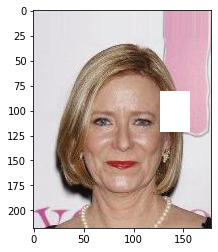

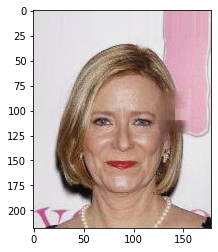

In [36]:
index_data=9
plt.imshow(incomplete_images[index_data])
plt.show()
plt.imshow(result_after[index_data])
plt.show()

In [ ]:
del masks
del feed_prediction
del result_after
del incomplete_images

In [28]:
(metrics_val_gen,metrics_val_disc) = gan.evaluate('/content/test/',256)

100%|██████████| 158/158 [04:31<00:00,  1.72s/it]


In [30]:
metrics_val_gen

array([5.84467978e-04, 9.24792156e-01])

In [31]:
metrics_val_disc

array([14.85320342,  0.5       ])